In [9]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow.keras.metrics as km
import tensorflow.keras.losses as kloss
import tensorflow.keras.backend as K

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
class IoU:
    def __init__(self, threshold=.5, name="IoU"):
        self.threshold = threshold
        self.__name__ = name

    def __call__(self, y_true, y_pred):
        a = y_true == 1
        b = y_pred > self.threshold
        inter = tf.cast(tf.math.logical_and(a, b), "float32")
        union = tf.cast(tf.math.logical_or(a, b), "float32")
        return tf.reduce_sum(inter, axis=[1,2,3]) / tf.reduce_sum(union, axis=[1,2,3])

class DiceBCE:
    def __init__(self, name=None, smooth=1e-6):
        self.__name__ = name
        self.smooth = smooth
        self.bce_loss = kloss.BinaryCrossentropy()

    def __call__(self, y_true, y_pred):
        bce = self.bce_loss(y_true, y_pred)
        intersection = K.sum(K.dot(y_true, y_pred))    
        dice = 1 - (2*intersection + self.smooth) / (K.sum(y_true) + K.sum(y_pred) + self.smooth)

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_mean(y_true * y_pred, axis=[1,2,3])
    denominator = tf.reduce_mean(y_true + y_pred, axis=[1,2,3])
    return 1 - numerator / denominator

def DiceBCELoss(y_true, y_pred, smooth=1e-6):    
       
    #flatten label and prediction tensors
    # inputs = K.flatten(inputs)
    # targets = K.flatten(targets)
    
    BCE =  (targets, inputs)
    intersection = K.sum(K.dot(targets, inputs))    
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

In [3]:
input_shape = (128, 128, 3)

conv_args = dict(kernel_size=(3,3), padding="same", activation="relu")

in_unet = Input(input_shape)
x = Conv2D(32, **conv_args)(in_unet)
x1 = Conv2D(32, **conv_args)(x)
x = MaxPool2D()(x1)

x = Conv2D(64, **conv_args)(x)
x2 = Conv2D(64, **conv_args)(x)
x = MaxPool2D()(x2)

x = Conv2D(128, **conv_args)(x)
x3 = Conv2D(128, **conv_args)(x)
x = MaxPool2D()(x3)

x = Conv2D(256, **conv_args)(x)
x4 = Conv2D(256, **conv_args)(x)
x = MaxPool2D()(x4)

x = Conv2D(512, **conv_args)(x)
x = Conv2D(512, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x4])
x = Conv2D(256, **conv_args)(x)
x = Conv2D(256, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x3])
x = Conv2D(128, **conv_args)(x)
x = Conv2D(128, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x2])
x = Conv2D(64, **conv_args)(x)
x = Conv2D(64, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x1])
x = Conv2D(32, **conv_args)(x)
x = Conv2D(32, **conv_args)(x)

out_unet = Conv2D(1, kernel_size=(3,3), padding="same", activation="sigmoid")(x)

unet = Model(in_unet, out_unet)

In [4]:
eval_metrics = [
    IoU(name="IoU"),
    km.BinaryAccuracy(name="accuracy",),
    km.AUC(name="ROC_AUC", curve="ROC"),
    km.Precision(name="precision"),
    km.Recall(name="recall")
]

unet.compile(loss=DiceBCELoss, optimizer="rmsprop",
             metrics=eval_metrics)

In [5]:
import data_generation

train_gen = data_generation.SegmentationDataGenerator("./test_dataset/train")
test_gen = data_generation.SegmentationDataGenerator("./test_dataset/test")

Found 14896 files.
Found 4965 files.


In [6]:
history = unet.fit(train_gen, validation_data=test_gen, epochs=10)

Epoch 1/10


ValueError: in user code:

    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\aleks\AppData\Local\Temp/ipykernel_7556/1507425714.py:29 DiceBCELoss  *
        intersection = K.sum(K.dot(targets, inputs))
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:1979 dot
        out = tf.matmul(x, y)
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\math_ops.py:3654 matmul
        return gen_math_ops.mat_mul(
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\gen_math_ops.py:5711 mat_mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\aleks\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 2 but is rank 1 for '{{node DiceBCELoss/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](DiceBCELoss/Reshape_1, DiceBCELoss/Reshape)' with input shapes: [?], [?].


In [9]:
def plot_metric(name, history, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(history[name], label=name)
    ax.plot(history[f"val_{name}"], label=f"val_{name}")
    ax.legend()
    return ax

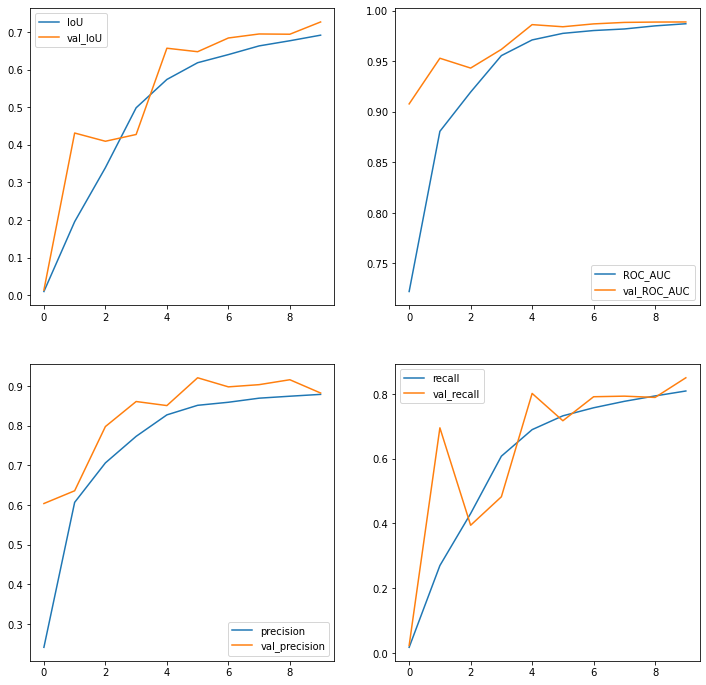

In [10]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
H = history.history
plot_metric("IoU", H, ax[0,0])
plot_metric("ROC_AUC", H, ax[0,1])
plot_metric("precision", H, ax[1,0])
plot_metric("recall", H, ax[1,1])
plt.show()

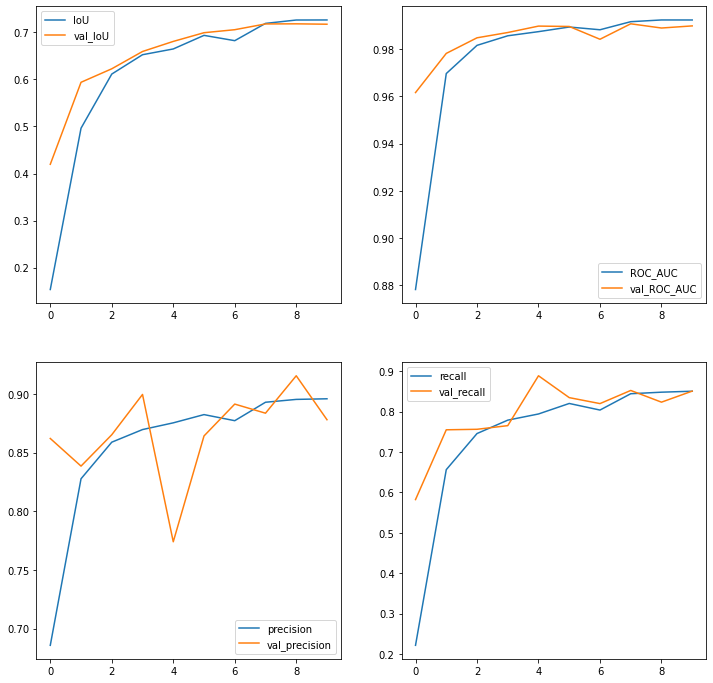

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
H = history.history
plot_metric("IoU", H, ax[0,0])
plot_metric("ROC_AUC", H, ax[0,1])
plot_metric("precision", H, ax[1,0])
plot_metric("recall", H, ax[1,1])
plt.show()

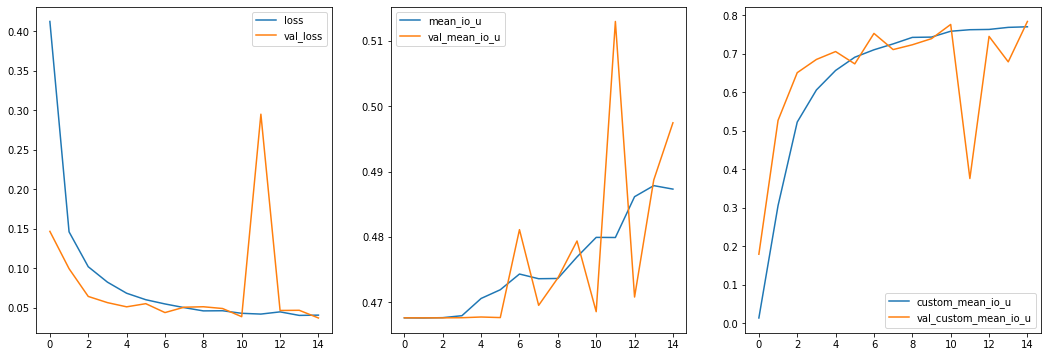

In [11]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
H = history.history
ax[0].plot(H["loss"], label="loss")
ax[0].plot(H["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(H["mean_io_u"], label="mean_io_u")
ax[1].plot(H["val_mean_io_u"], label="val_mean_io_u")
ax[1].legend()
ax[2].plot(H["custom_mean_io_u"], label="custom_mean_io_u")
ax[2].plot(H["val_custom_mean_io_u"], label="val_custom_mean_io_u")
ax[2].legend()
plt.show()

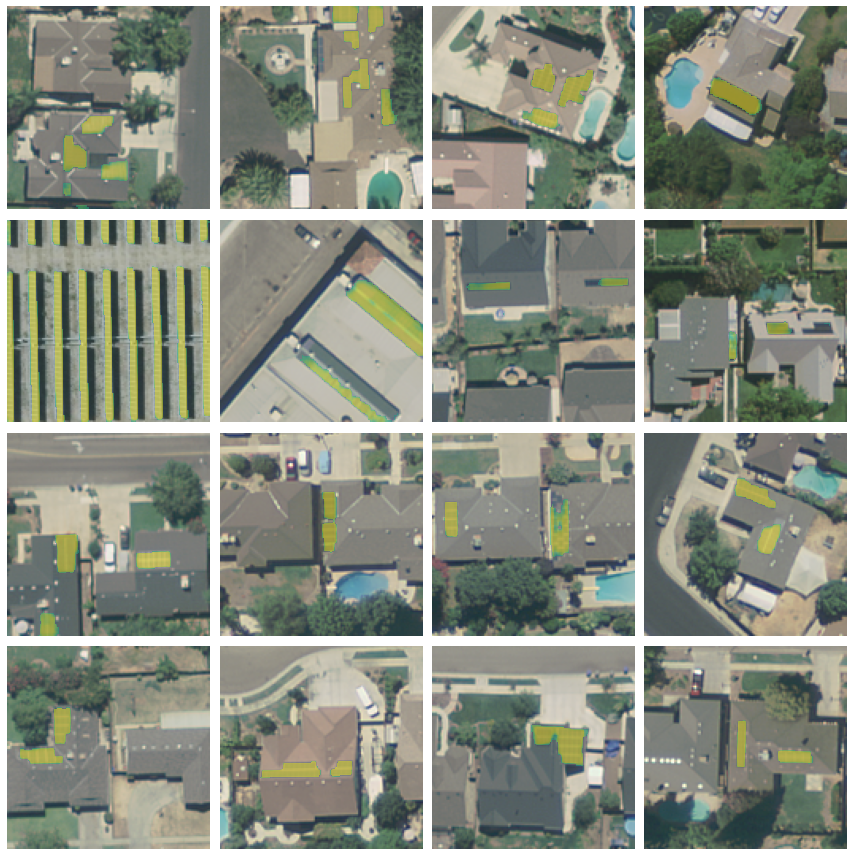

In [17]:
X, y = test_gen.__getitem__(6)
y_pred = unet.predict(X)

w, h = 4, 4
fig, ax = plt.subplots(h, w, figsize=(12,12))

for i in range(h):
    for j in range(w):
        ax[i,j].imshow(X[w*i+j])
        # ax[i,j].imshow(y[w*i+j,:,:,0], cmap="gray")
        ax[i,j].imshow(np.ma.masked_less(y_pred[w*i+j,:,:,0], .5), vmin=0, vmax=1, alpha=.5)
        # ax[i,j].imshow(y_pred[w*i+j,:,:,0], vmin=0, vmax=1, alpha=.5)
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()

In [24]:
unet = keras.models.load_model("trained_models/Unet/unet_v4.tf")

ValueError: Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.

In [12]:
unet.save(r"trained_models\Unet\unet_v4.tf")

INFO:tensorflow:Assets written to: trained_models\Unet\unet_v4.tf\assets


In [13]:
y_pred = unet.predict(X)

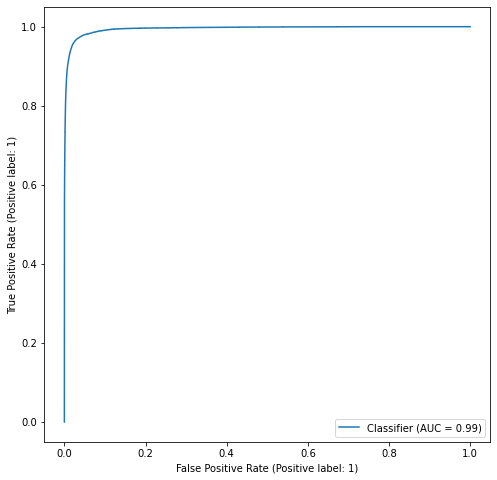

In [14]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_predictions(y.reshape(-1), y_pred.reshape(-1), ax=ax)

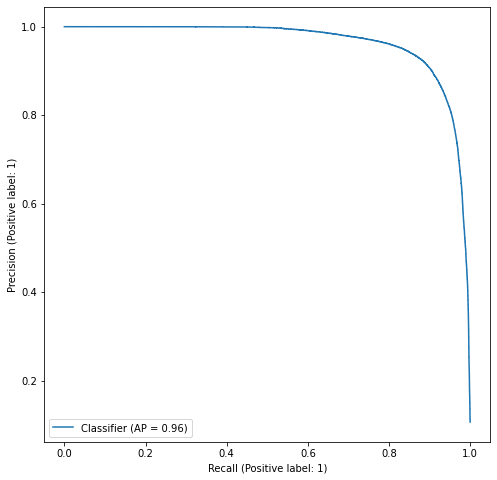

In [16]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(8,8))
PrecisionRecallDisplay.from_predictions(y.reshape(-1), y_pred.reshape(-1), ax=ax)

# Test Gers Data

In [22]:
import data_generation

gers_gen = data_generation.SegmentationDataGenerator("./gers_dataset2")

Found 2232 files.


In [23]:
unet_eval = unet.evaluate(gers_gen)

69/69 [==============================] - 16s 236ms/step - loss: 0.1805 - IoU: 0.7031 - accuracy: 0.9450 - ROC_AUC: 0.9778 - precision: 0.8884 - recall: 0.8930


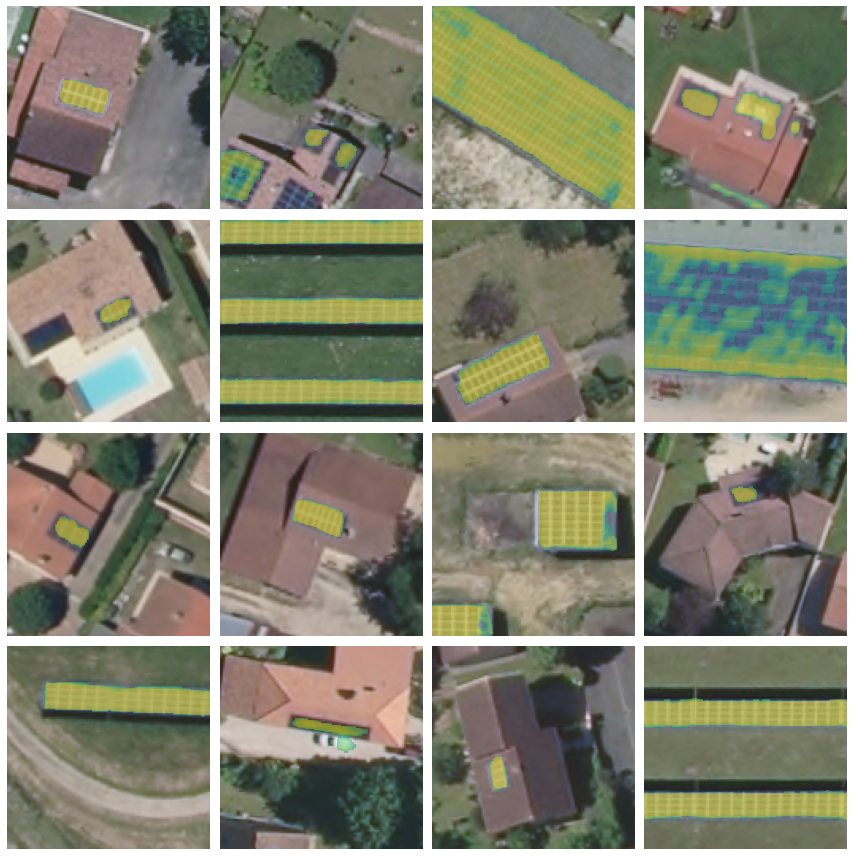

In [26]:
Xg, yg = gers_gen.__getitem__(57)
yg_pred = unet.predict(Xg)

w, h = 4, 4
fig, ax = plt.subplots(h, w, figsize=(12,12))

for i in range(h):
    for j in range(w):
        ax[i,j].imshow(Xg[w*i+j])
        # ax[i,j].imshow(y[w*i+j,:,:,0], cmap="gray")
        ax[i,j].imshow(np.ma.masked_less(yg_pred[w*i+j,:,:,0], .5), vmin=0, vmax=1, alpha=.5)
        # ax[i,j].imshow(y_pred[w*i+j,:,:,0], vmin=0, vmax=1, alpha=.5)
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()